## 1. Import Libraries

In [5]:
import numpy as np
import os
import shutil
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# 2. Define Image Size and Batch Size:

In [2]:
IMAGE_SIZE = 224 # define the image size for all images (height and Width = 224 X 224)
BATCH_SIZE = 32  # At the time of training 64 images will be there at a time

# 3. Set Folder Paths:

In [3]:
base_dir = "/kaggle/input/tomatoleaf/tomato"
train_dir = "/kaggle/input/tomatoleaf/tomato/train"
validation_dir = "/kaggle/input/tomatoleaf/tomato/val"

In [4]:
import os
import shutil

# Define paths
base_dir = "/kaggle/input/tomatoleaf/tomato"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "val")
merged_dir = "/kaggle/working/merged_dataset"

# Create merged directory if it doesn't exist
if not os.path.exists(merged_dir):
    os.makedirs(merged_dir)

# Function to merge folders
def merge_folders(src_dir, dest_dir):
    for class_name in os.listdir(src_dir):
        class_dir = os.path.join(src_dir, class_name)
        target_dir = os.path.join(dest_dir, class_name)
        
        if not os.path.exists(target_dir):
            os.makedirs(target_dir)
        
        for fname in os.listdir(class_dir):
            shutil.copy(os.path.join(class_dir, fname), os.path.join(target_dir, fname))

# Merge train and validation directories into merged directory
merge_folders(train_dir, merged_dir)
merge_folders(validation_dir, merged_dir)

print(f"Files merged into {merged_dir}")


Files merged into /kaggle/working/merged_dataset


In [5]:
import os

# Path to the merged dataset directory
merged_dir = "/kaggle/working/merged_dataset"

# Initialize a dictionary to store the count of images in each class
image_count_per_class = {}

# Iterate over each subfolder (class)
for class_name in os.listdir(merged_dir):
    class_dir = os.path.join(merged_dir, class_name)
    if os.path.isdir(class_dir):
        # Count the number of images in the current subfolder
        num_images = len(os.listdir(class_dir))
        image_count_per_class[class_name] = num_images

# Print the total number of images for each class
for class_name, count in image_count_per_class.items():
    print(f"Class: {class_name} has {count} images")

# Print the total number of images in the merged dataset
total_images = sum(image_count_per_class.values())
print(f"Total number of images in the merged dataset: {total_images}")


Class: Tomato___Tomato_Yellow_Leaf_Curl_Virus has 1100 images
Class: Tomato___healthy has 1100 images
Class: Tomato___Target_Spot has 1100 images
Class: Tomato___Bacterial_spot has 1100 images
Class: Tomato___Early_blight has 1100 images
Class: Tomato___Septoria_leaf_spot has 1100 images
Class: Tomato___Tomato_mosaic_virus has 1100 images
Class: Tomato___Spider_mites Two-spotted_spider_mite has 1100 images
Class: Tomato___Late_blight has 1100 images
Class: Tomato___Leaf_Mold has 1100 images
Total number of images in the merged dataset: 11000


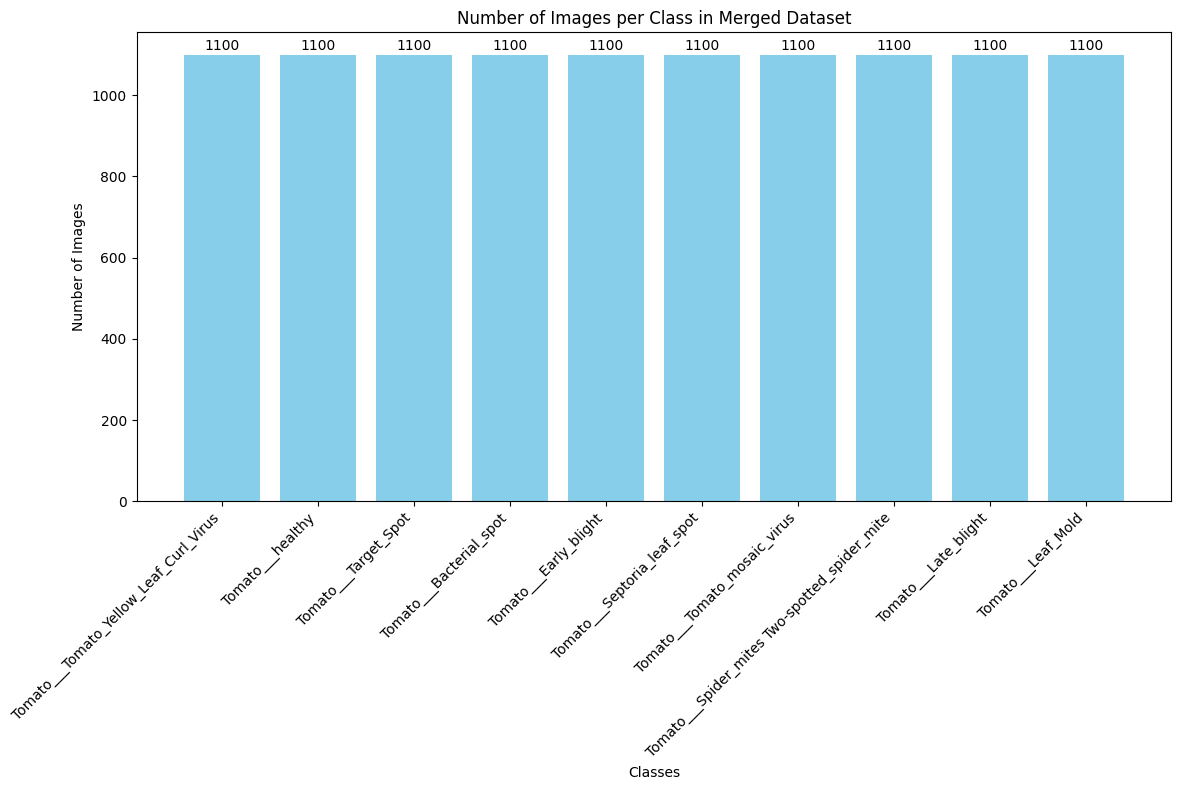

In [6]:
import os
import matplotlib.pyplot as plt

# Path to the merged dataset directory
merged_dir = "/kaggle/working/merged_dataset"

# Count the total number of images in each class
image_count_per_class = {}
for class_name in os.listdir(merged_dir):
    class_dir = os.path.join(merged_dir, class_name)
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))
        image_count_per_class[class_name] = num_images

# Plotting the bar chart
plt.figure(figsize=(12, 8))
bars = plt.bar(image_count_per_class.keys(), image_count_per_class.values(), color='skyblue')

# Adding annotations on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')

plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Merged Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [7]:
# Step 2: Apply 10-fold cross-validation
# Load the combined dataset
data_gen = ImageDataGenerator(rescale=1./255)
data_flow = data_gen.flow_from_directory(merged_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

Found 11000 images belonging to 10 classes.


In [4]:
# Convert to numpy arrays for easier splitting
X = []
y = []
data_flow = data_gen.flow_from_directory(merged_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

# Iterate through the DirectoryIterator
for images, labels in data_flow:
    X.append(images)
    y.append(labels)
    # Stop if one full pass through the data has been made
    if len(X) * data_flow.batch_size >= data_flow.samples:
        break

X = np.concatenate(X)
y = np.concatenate(y)

NameError: name 'data_gen' is not defined

In [3]:
# Step 2: Apply 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Training on fold {fold+1}")

    train_images, val_images = X[train_idx], X[val_idx]
    train_labels, val_labels = y[train_idx], y[val_idx]

    # Create ImageDataGenerators for training and validation
    train_datagen = ImageDataGenerator()
    val_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
    val_generator = val_datagen.flow(val_images, val_labels, batch_size=32)

    # Load the VGG16 model without the top layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)

    # Use sigmoid activation if you have a binary classification problem or multi-label classification
    predictions = Dense(len(data_flow.class_indices), activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze all layers in the base model initially
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='binary_crossentropy' if len(data_flow.class_indices) == 2 else 'categorical_crossentropy', 
                  metrics=['accuracy'])

    # Train the model
    model.fit(train_generator, validation_data=val_generator, epochs=10)

    # Unfreeze some of the top layers for fine-tuning
    for layer in base_model.layers[-4:]:
        layer.trainable = True

    # Recompile the model
    model.compile(optimizer=Adam(learning_rate=0.00001), 
                  loss='binary_crossentropy' if len(data_flow.class_indices) == 2 else 'categorical_crossentropy', 
                  metrics=['accuracy'])

    # Continue training the model
    model.fit(train_generator, validation_data=val_generator, epochs=10)

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(val_generator)
    fold_accuracies.append(val_accuracy)

NameError: name 'X' is not defined

In [ ]:
# Calculate the average accuracy across all folds
average_accuracy = np.mean(fold_accuracies)
print(f"Average Accuracy across all folds: {average_accuracy}")